# Exercise 1

In [ ]:
import tensorflow as tf

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(keras.__version__)

2.7.0


<b>The cell below doesn't work but needs to stay here as a reference</b>

In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, required=True, help='model name')
# parser.add_argument('--labels', type=int, required=True, help='model output')
# args = parser.parse_args()


seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True,
    cache_dir='.', cache_subdir='data')
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

column_indices = [2, 5]
columns = df.columns[column_indices]
data = df[columns].values.astype(np.float32)

n = len(data)
train_data = data[0:int(n * 0.7)]
val_data = data[int(n * 0.7):int(n * 0.9)]
test_data = data[int(n * 0.9):]

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

input_width = 6
LABEL_OPTIONS = 2  # args.labels


class WindowGenerator:
    def __init__(self, input_width, label_options, mean, std):
        self.input_width = input_width
        self.label_options = label_options
        self.mean = tf.reshape(tf.convert_to_tensor(mean), [1, 1, 2])
        self.std = tf.reshape(tf.convert_to_tensor(std), [1, 1, 2])

    def split_window(self, features): #used to convert the the list of args into a set of features and labels 
        inputs = features[:, :-1, :]

        if self.label_options < 2:
            labels = features[:, -1, self.label_options]
            labels = tf.expand_dims(labels, -1)
            num_labels = 1
        else:
            labels = features[:, -1, :]
            num_labels = 2
        print(labels)
        
        inputs.set_shape([None, self.input_width, 2])
        labels.set_shape([None, num_labels])
        print(labels)
        return inputs, labels

    def normalize(self, features):
        features = (features - self.mean) / (self.std + 1.e-6)

        return features

    def preprocess(self, features):
        inputs, labels = self.split_window(features)
        inputs = self.normalize(inputs)

        return inputs, labels

    def make_dataset(self, data, train):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=input_width + 1,
            sequence_stride=1,
            batch_size=32)
        ds = ds.map(self.preprocess)
        ds = ds.cache()
        if train is True:
            ds = ds.shuffle(100, reshuffle_each_iteration=True)

        return ds


generator = WindowGenerator(input_width, LABEL_OPTIONS, mean, std)
train_ds = generator.make_dataset(train_data, True)
val_ds = generator.make_dataset(val_data, False)
test_ds = generator.make_dataset(test_data, False)

class MultiOutputMAE(tf.keras.metrics.Metric):
    def __init__(self, name='mean_absolute_error', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight('total', initializer='zeros', shape=(2,))
        self.count = self.add_weight('count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.abs(y_pred - y_true)
        error = tf.reduce_mean(error, axis=0)
        self.total.assign_add(error)
        self.count.assign_add(1.)

        return

    def result(self):
        result = tf.math.divide_no_nan(self.total, self.count)

        return result




#now we create our models
# mlp=tf.keras.Sequential([
#     layers.Flatten(), 
#     layers.Dense(units=128,activation='relu'),
#     layers.Dense(units=128,activation='relu'),
#     layers.Dense(units=2)])



# cnn=tf.keras.Sequential([
#     layers.Conv1D(filters=64,kernel_size=(3,),activation='relu'),
#     layers.Flatten(),
#     layers.Dense(units=64,activation='relu'),
#     layers.Dense(units=2)
# ])


# lstm=tf.keras.Sequential([
#     layers.LSTM(64),
#     layers.Flatten(),
#     layers.Dense(units=2)
# ])

model = keras.Sequential()
model.add(keras.Input(shape=(6,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(units=12))


loss=tf.losses.MeanSquaredError()
optimizer=tf.optimizers.Adam()

#now we can compile and then fit our model
metrics=[MultiOutputMAE()]
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

model.fit(train_ds,epochs=20,validation_data=val_ds,verbose=2)

saved_model_dir='./result'

run_model = tf.function(lambda x: model(x))
concrete_func = run_model.get_concrete_function(tf.TensorSpec([1, 6, 2],
tf.float32))
model.save(saved_model_dir, signatures=concrete_func)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

<b>It works from here</b> <br>
<b>Adding the libraries and importing the dataset </b> <br>


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import pandas as pd


In [2]:
#importing the dataset 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True,
    cache_dir='.', cache_subdir='data')
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

column_indices = [2, 5]
columns = df.columns[column_indices]
data = df[columns].values.astype(np.float32)

n = len(data)
train_data = data[0:int(n * 0.7)]
val_data = data[int(n * 0.7):int(n * 0.9)]
test_data = data[int(n * 0.9):]

#to normalized the data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)


#input width = 6
#number of labels=2

# First approach
we use libraries in this approach <br>
It needs some working (doesn't acutally work yet)

In [ ]:
#train data is an array, so we can easily use it
new_train_data=[]
for item in train_data:
    for i in item:
        new_train_data.append(i)
        
new_train_data = np.array(new_train_data)
        

new_train_data=new_train_data.reshape((len(new_train_data),1))

In [ ]:
train_data

In [ ]:
print(new_train_data)
new_train_data.shape

In [ ]:
#creating the dataset with libraries
from keras.preprocessing.sequence import TimeseriesGenerator
steps=len(train_data)//32

n_features = train_data.shape[1]
n_input = 6
generator = TimeseriesGenerator(new_train_data,new_train_data,length=12, batch_size=32,stride=2) 
#stride is equal to 2 because we have a list with length of 12


# define model

model = keras.Sequential()
model.add(keras.Input(shape=(1,12)))
model.add(layers.Flatten())
model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(units=12))

#the problem was the fact that we used the value 12 for units in dense layers


model.summary()




In [ ]:

# metrics=[MultiOutputMAE()]

#now we can compile and then fit our model
loss=tf.losses.MeanSquaredError()
optimizer=tf.optimizers.Adam()

model.compile(loss='mae',optimizer='adam')

model.fit(generator,steps_per_epoch=steps,epochs=20,verbose=2)


yhat = model.predict(generator, verbose=2)
print(yhat)


# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
# model.add(Dense(2))
# model.compile(optimizer='adam', loss='mse')
# fit model
# model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)
#  make a one step prediction out of sample
# x_input = np.array([[-8, 93], [-7, 89]]).reshape((1, n_input, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
batch_0 = generator[0]
x, y = batch_0
print(x[0])
print(' ---------------')
print(y[0])

In [ ]:
batch_0 = generator[0]
x, y = batch_0
print(x[1])
print(' ---------------')
print(y[0])

# Second approach
 with for loop

In [3]:
def window_gen(data,input_length,output_length,vectorize): #output_length is actually output step
    x=[]
    y=[]
    for index in range(0,len(data)-input_length-output_length):
        x.append(data[index:index+input_length])
        output_loc=data[index+input_length:index+input_length+output_length]
        if vectorize==True:
            y.append(output_loc.reshape(-1))
        else:
            y.append(output_loc)
    x=np.array(x) #to make it possible to run
    y=np.array(y)
    return x,y

In [4]:
#normalization
def mean_std(x,y):
    x_mean=np.mean(x,axis=0)
    y_mean=np.mean(y,axis=0)
    x_std=np.std(x,axis=0)
    y_std=np.std(y,axis=0)
    return x_mean,y_mean,x_std,y_std

def normalization(x,y,x_mean,y_mean,x_std,y_std):
    x_norm=(x - x_mean) / (x_std+ 1.e-6)
    y_norm=(y - y_mean) / (y_std + 1.e-6)
    
#     f = lambda i: (i - x_mean) / (x_std + 1.e-6)
#     g= lambda j:(j - y_mean) / (y_std + 1.e-6)

#     x_new=[f(i) for i in x]
#     y_new=[f(j) for j in y]
    return x_norm,y_norm

# mean = train_data.mean(axis=0)
# std = train_data.std(axis=0)   

<b>Training data</b>

In [ ]:
x_train,y_train=window_gen(train_data,6,3,False)

In [ ]:
x_train,y_train=window_gen(train_data,6,3,True)

In [ ]:
x_train,y_train=window_gen(train_data,6,9,False)

In [ ]:
x_train,y_train=window_gen(train_data,6,9,True)

<b>Validation Data</b>

In [ ]:
x_val,y_val=window_gen(train_data,6,3,False)

In [ ]:
x_val,y_val=window_gen(train_data,6,3,True)

In [ ]:
x_val,y_val=window_gen(train_data,6,9,False)

In [ ]:
x_val,y_val=window_gen(train_data,6,9,True)

<b>Testing Data </b>

In [ ]:
x_test,y_test=window_gen(train_data,6,3,False)

In [ ]:
x_test,y_test=window_gen(train_data,6,3,True)

In [ ]:
x_test,y_test=window_gen(train_data,6,9,False)

In [ ]:
x_test,y_test=window_gen(train_data,6,9,True)

<b>MLP</b>


In [59]:

#now we can train our model
#we have to train the model for each of our output_steps
output_steps=9
input_steps=6

x_train,y_train=window_gen(train_data,input_steps,output_steps,True)

x_mean_mlp,y_mean_mlp,x_std_mlp,y_std_mlp=mean_std(x_train,y_train)

x_train_norm,y_train_norm=normalization(x_train,y_train,x_mean_mlp,y_mean_mlp,x_std_mlp,y_std_mlp)


alpha=0.25
mlp = keras.Sequential()
mlp.add(keras.Input(shape=(input_steps,2)))
mlp.add(layers.Flatten())
mlp.add(layers.Dense(units=128*alpha,activation='relu'))
mlp.add(layers.Dense(units=128*alpha,activation='relu'))
mlp.add(layers.Dense(units=output_steps*2))

mlp.summary()

loss=tf.losses.MeanSquaredError()
optimizer=tf.optimizers.Adam()

mlp.compile(loss='mae',optimizer='adam')

mlp.fit(x_train_norm,y_train_norm,batch_size=32,epochs=20)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                416       
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 18)                594       
                                                                 
Total params: 2,066
Trainable params: 2,066
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
9200/9200 [==============================] - 6s 651us/step - loss: 0.1054
Epoch 2/20
9200/9200 [==============================] - 6s 607us/step - loss: 0.0943
Epoch 3/20
920

In [60]:
yhat = mlp.predict(x_train, verbose=2)
print(yhat)

9200/9200 - 4s - 4s/epoch - 389us/step
[[-4.5494423  95.199745    1.416396   ... 19.014387   27.431658
   9.519208  ]
 [-4.035059   95.859116    2.2126925  ... 15.87109    28.843695
   6.15148   ]
 [-4.099407   95.9666      2.324702   ... 13.573648   29.550154
   3.6145768 ]
 ...
 [20.406921   94.59344    27.054295   ... 10.999166   55.48583
   0.34375823]
 [20.809341   93.62909    27.684422   ...  7.2484407  56.977467
  -3.7626357 ]
 [20.63607    93.36774    27.43395    ...  7.853176   56.695553
  -3.1534476 ]]


<b>Now we are performing validation and testing for the output steps of 3<b>

In [39]:
output_steps=3
input_steps=6
#creating the val and test dataset
x_val3,y_val3=window_gen(val_data,input_steps,output_steps,True)
x_test3,y_test3=window_gen(test_data,input_steps,output_steps,True)

x_val_norm3,y_val_norm3=normalization(x_val3,y_val3,x_mean_mlp,y_mean_mlp,x_std_mlp,y_std_mlp)
x_test_norm3,y_test_norm3=normalization(x_test3,y_test3,x_mean_mlp,y_mean_mlp,x_std_mlp,y_std_mlp)

In [40]:
y_val_predict_mlp3=mlp.predict(x_val_norm3,verbose=2)

2629/2629 - 1s - 981ms/epoch - 373us/step


In [41]:
y_test_predict_mlp3=mlp.predict(x_test_norm3,verbose=2)

1314/1314 - 1s - 606ms/epoch - 461us/step


In [42]:
val_mae_mlp3=tf.keras.metrics.mean_absolute_error(y_val_norm3,y_val_predict_mlp3)
print(np.mean(val_mae_mlp3))

0.04632742


In [43]:
test_mae_mlp3=tf.keras.metrics.mean_absolute_error(y_test_norm3,y_test_predict_mlp3)
print(np.mean(test_mae_mlp3))

0.050006174


In [44]:
#seperating temperature from humidity in our data
y_val_temperature3=y_val_norm3[:, 0::2]
y_val_humidity3=y_val_norm3[:, 1::2]
y_val_temperature_predict3=y_val_predict_mlp3[:, 0::2]
y_val_humidity_predict3=y_val_predict_mlp3[:, 1::2]


y_test_temperature3=y_test_norm3[:, 0::2]
y_test_humidity3=y_test_norm3[:, 1::2]
y_test_temperature_predict_mlp3=y_test_predict_mlp3[:, 0::2]
y_test_humidity_predict_mlp3=y_test_predict_mlp3[:, 1::2]

In [45]:
val_temperature_mae_mlp3=tf.keras.metrics.mean_absolute_error(y_val_temperature3,y_val_temperature_predict3)
print(np.mean(val_temperature_mae_mlp3))

0.02657633


In [46]:
val_humidity_mae_mlp3=tf.keras.metrics.mean_absolute_error(y_val_humidity3,y_val_humidity_predict3)
print(np.mean(val_humidity_mae_mlp3))

0.0660785


In [47]:
test_temperature_mae_mlp3=tf.keras.metrics.mean_absolute_error(y_test_temperature3,y_test_temperature_predict_mlp3)
print(np.mean(test_temperature_mae_mlp3))

0.028811572


In [48]:
test_humidity_mae_mlp3=tf.keras.metrics.mean_absolute_error(y_test_humidity3,y_test_humidity_predict_mlp3)
print(np.mean(test_humidity_mae_mlp3))

0.07120079


<b>Now we are performing validation and testing for the output steps of 9<b>

In [68]:
output_steps=9
input_steps=6
#creating the val and test dataset
x_val9,y_val9=window_gen(val_data,input_steps,output_steps,True)
x_test9,y_test9=window_gen(test_data,input_steps,output_steps,True)

x_val_norm9,y_val_norm9=normalization(x_val9,y_val9,x_mean_mlp,y_mean_mlp,x_std_mlp,y_std_mlp)
x_test_norm9,y_test_norm9=normalization(x_test9,y_test9,x_mean_mlp,y_mean_mlp,x_std_mlp,y_std_mlp)

In [69]:
y_val_predict_mlp9=mlp.predict(x_val_norm9,verbose=2)
val_mae9=tf.keras.metrics.mean_absolute_error(y_val_norm9,y_val_predict9)
print(np.mean(val_mae9))

2628/2628 - 1s - 944ms/epoch - 359us/step
0.089226566


In [72]:
y_test_predict_mlp9=mlp.predict(x_test_norm9,verbose=2)
test_mae_mlp9=tf.keras.metrics.mean_absolute_error(y_test_norm9,y_test_predict_mlp9)
print(np.mean(test_mae_mlp9))

1314/1314 - 0s - 491ms/epoch - 374us/step
0.09315769


In [73]:
#seperating temperature from humidity in our data

y_val_temperature9=y_val_norm9[:, 0::2]
y_val_humidity9=y_val_norm9[:, 1::2]
y_val_temperature_predict9=y_val_predict_mlp9[:, 0::2]
y_val_humidity_predict9=y_val_predict_mlp9[:, 1::2]


y_test_temperature9=y_test_norm9[:, 0::2]
y_test_humidity9=y_test_norm9[:, 1::2]
y_test_temperature_predict_mlp9=y_test_predict_mlp9[:, 0::2]
y_test_humidity_predict_mlp9=y_test_predict_mlp9[:, 1::2]

In [74]:
val_temperature_mae9=tf.keras.metrics.mean_absolute_error(y_val_temperature9,y_val_temperature_predict9)
print(np.mean(val_temperature_mae9))

0.05137715


In [75]:
val_humidity_mae9=tf.keras.metrics.mean_absolute_error(y_val_humidity9,y_val_humidity_predict9)
print(np.mean(val_humidity_mae9))

0.12707599


In [76]:
test_temperature_mae_mlp9=tf.keras.metrics.mean_absolute_error(y_test_temperature9,y_test_temperature_predict_mlp9)
print(np.mean(test_temperature_mae_mlp9))

0.054092437


In [77]:
test_humidity_mae_mlp9=tf.keras.metrics.mean_absolute_error(y_test_humidity9,y_test_humidity_predict_mlp9)
print(np.mean(test_humidity_mae_mlp9))

0.13222294


<b>Run the below cells for the pruning procedure</b></br>
<b>We have to use the normalized train and test data <br>
We have to consider the number of outputs in order to use the right test data (3 or 9) </b> <br>
 x_test_norm3, y_test_norm3<br>
<b>OR</b> <br>
 x_test_norm9, y_test_norm9 <br>

In [79]:
import tensorflow_model_optimization as tfmot
import tempfile
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 20
validation_split = 0.2  # 10% of training set will be used for validation set.

num_images = 294370 * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                             final_sparsity=0.9,
                                                             begin_step=0,
                                                             end_step=end_step)
}

model_for_pruning = prune_low_magnitude(mlp, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.MeanAbsoluteError(),
                          metrics=['mae'])

model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train_norm, y_train_norm,
                      batch_size=batch_size, epochs=epochs, callbacks=callbacks)
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
    x_test9, y_test9, verbose=0)

print('Pruned test accuracy:', model_for_pruning_accuracy)
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 12)               1         
 _2 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_6  (None, 32)               802       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_7  (None, 32)               2082      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_8  (None, 18)               1172      
  (PruneLowMagnitude)                                            
                                                                 
Total params: 4,057
Trainable params: 2,066
Non-traina

9200/9200 [==============================] - 9s 905us/step - loss: 0.0913 - mae: 0.0913
Epoch 2/20
9200/9200 [==============================] - 8s 849us/step - loss: 0.0907 - mae: 0.0907
Epoch 3/20
9200/9200 [==============================] - 8s 829us/step - loss: 0.0904 - mae: 0.0904
Epoch 4/20
9200/9200 [==============================] - 8s 904us/step - loss: 0.0901 - mae: 0.0901
Epoch 5/20
9200/9200 [==============================] - 8s 877us/step - loss: 0.0897 - mae: 0.0897
Epoch 6/20
9200/9200 [==============================] - 8s 840us/step - loss: 0.0896 - mae: 0.0896
Epoch 7/20
9200/9200 [==============================] - 8s 860us/step - loss: 0.0896 - mae: 0.0896
Epoch 8/20
9200/9200 [==============================] - 9s 926us/step - loss: 0.0897 - mae: 0.0897
Epoch 9/20
9200/9200 [==============================] - 8s 906us/step - loss: 0.0901 - mae: 0.0901
Epoch 10/20
9200/9200 [==============================] - 8s 886us/step - loss: 0.0905 - mae: 0.0905
Epoch 11/20
9200/920

Saved pruned Keras model to: C:\Users\aligh\AppData\Local\Temp\tmpn5knofl7.h5
INFO:tensorflow:Assets written to: C:\Users\aligh\AppData\Local\Temp\tmpoo248cpc\assets


INFO:tensorflow:Assets written to: C:\Users\aligh\AppData\Local\Temp\tmpoo248cpc\assets


Saved pruned TFLite model to: C:\Users\aligh\AppData\Local\Temp\tmprc77ap99.tflite


In [80]:
import zlib, sys

filename_in = "C:/Users/aligh/AppData/Local/Temp/tmprc77ap99.tflite"
filename_out = "./compressed_cnn9.tflite.zlib"

with open(filename_in, mode="rb") as fin, open(filename_out, mode="wb") as fout:
    data = fin.read()
    compressed_data = zlib.compress(data, 9)
    print(f"Original size: {sys.getsizeof(data)}")
    # Original size: 1000033
    print(f"Compressed size: {sys.getsizeof(compressed_data)}")
    # Compressed size: 1024

    fout.write(compressed_data)

Original size: 7345
Compressed size: 2206


<b>MAE for the pruned model  <br>
(The MAE of the models after the pruning)</b> <br>

 <b>output=9

In [81]:
y_test_predict_mlp9_prune=model_for_pruning.predict(x_test_norm9,verbose=2)

1314/1314 - 1s - 566ms/epoch - 431us/step


In [82]:
y_test_temperature_mlp9=y_test_norm9[:, 0::2]
y_test_humidity_mlp9=y_test_norm9[:, 1::2]
y_test_temperature_predict_mlp9_prune=y_test_predict_mlp9_prune[:, 0::2]
y_test_humidity_predict_mlp9_prune=y_test_predict_mlp9_prune[:, 1::2]


In [83]:
test_temperature_mae_mlp9_prune=tf.keras.metrics.mean_absolute_error(y_test_temperature_mlp9,y_test_temperature_predict_mlp9_prune)
print(np.mean(test_temperature_mae_mlp9_prune))

0.05768358


In [85]:
test_humidity_mae_mlp9_prune=tf.keras.metrics.mean_absolute_error(y_test_humidity_mlp9,y_test_humidity_predict_mlp9_prune)
print(np.mean(test_humidity_mae_mlp9_prune))

0.13139595


<b>output=3

In [55]:
y_test_predict_mlp3_prune=model_for_pruning.predict(x_test_norm3,verbose=2)

1314/1314 - 0s - 485ms/epoch - 369us/step


In [56]:
y_test_temperature_mlp3=y_test_norm3[:, 0::2]
y_test_humidity_mlp3=y_test_norm3[:, 1::2]
y_test_temperature_predict_mlp3_prune=y_test_predict_mlp3_prune[:, 0::2]
y_test_humidity_predict_mlp3_prune=y_test_predict_mlp3_prune[:, 1::2]


In [57]:
test_temperature_mae_mlp3_prune=tf.keras.metrics.mean_absolute_error(y_test_temperature_mlp3,y_test_temperature_predict_mlp3_prune)
print(np.mean(test_temperature_mae_mlp3_prune))

0.028665833


In [58]:
test_humidity_mae_mlp3_prune=tf.keras.metrics.mean_absolute_error(y_test_humidity_mlp3,y_test_humidity_predict_mlp3_prune)
print(np.mean(test_humidity_mae_mlp3_prune))

0.06857006


<b>CNN</b>


In [39]:

output_steps=3
input_steps=6

x_train,y_train=window_gen(train_data,input_steps,output_steps,True)

x_mean_cnn,y_mean_cnn,x_std_cnn,y_std_cnn=mean_std(x_train,y_train)

x_train_norm,y_train_norm=normalization(x_train,y_train,x_mean_cnn,y_mean_cnn,x_std_cnn,y_std_cnn)


alpha=0.25
cnn=tf.keras.Sequential([
    layers.Conv1D(filters=64*alpha,kernel_size=(3,),activation='relu'),
    layers.Flatten(),
    layers.Dense(units=64*alpha,activation='relu'),
    layers.Dense(units=output_steps*2)
])


cnn.compile(loss='mae',optimizer='adam')



loss=tf.losses.MeanSquaredError()
optimizer=tf.optimizers.Adam()



cnn.fit(x_train_norm,y_train_norm,batch_size=32,epochs=20) 
#To Do: decrease the learning rate a little bit

cnn.summary()

Epoch 1/20
9200/9200 [==============================] - 6s 665us/step - loss: 0.0634
Epoch 2/20
9200/9200 [==============================] - 6s 678us/step - loss: 0.0502
Epoch 3/20
9200/9200 [==============================] - 6s 679us/step - loss: 0.0490
Epoch 4/20
9200/9200 [==============================] - 6s 656us/step - loss: 0.0483
Epoch 5/20
9200/9200 [==============================] - 6s 650us/step - loss: 0.0478
Epoch 6/20
9200/9200 [==============================] - 6s 654us/step - loss: 0.0475
Epoch 7/20
9200/9200 [==============================] - 6s 654us/step - loss: 0.0475
Epoch 8/20
9200/9200 [==============================] - 6s 647us/step - loss: 0.0473
Epoch 9/20
9200/9200 [==============================] - 6s 646us/step - loss: 0.0472
Epoch 10/20
9200/9200 [==============================] - 6s 651us/step - loss: 0.0471
Epoch 11/20
9200/9200 [==============================] - 6s 646us/step - loss: 0.0470
Epoch 12/20
9200/9200 [==============================] - 6s 651

In [40]:
yhat = cnn.predict(x_train_norm, verbose=2)
print(yhat)

9200/9200 - 4s - 4s/epoch - 385us/step
[[-1.9662133   1.0877624  -1.9563715   1.077068   -1.9474559   1.0571493 ]
 [-1.9046162   1.1029911  -1.8839453   1.0812174  -1.8700521   1.0523007 ]
 [-1.9391726   1.1410359  -1.9223863   1.1347786  -1.9092234   1.1121951 ]
 ...
 [ 0.65759003  1.1777014   0.64832443  1.1862938   0.63872784  1.1922685 ]
 [ 0.6843612   1.1444333   0.67700785  1.1473686   0.6706541   1.1487209 ]
 [ 0.6212601   1.1567677   0.6130862   1.1731272   0.60316175  1.1830002 ]]


In [41]:
y_train_norm[0]

array([-1.9330546,  1.141171 , -1.9330804,  1.1170117, -1.9666122,
        1.0807725], dtype=float32)

In [42]:
y_train_norm[-1]

array([0.6265647, 1.1894891, 0.6092276, 1.2015688, 0.6184671, 1.207608 ],
      dtype=float32)

<b>Run the below cells for validation and testing for the output steps of 3<b>

In [43]:
output_steps=3
input_steps=6

x_val3,y_val3=window_gen(val_data,input_steps,output_steps,True)
x_test3,y_test3=window_gen(test_data,input_steps,output_steps,True)


x_val_norm3,y_val_norm3=normalization(x_val3,y_val3,x_mean_cnn,y_mean_cnn,x_std_cnn,y_std_cnn)
x_test_norm3,y_test_norm3=normalization(x_test3,y_test3,x_mean_cnn,y_mean_cnn,x_std_cnn,y_std_cnn)

In [44]:
y_val_predict_cnn3=cnn.predict(x_val_norm3,verbose=2)

2629/2629 - 1s - 983ms/epoch - 374us/step


In [45]:
y_test_predict_cnn3=cnn.predict(x_test_norm3,verbose=2)

1314/1314 - 0s - 500ms/epoch - 380us/step


In [46]:
y_val_temperature_cnn3=y_val_norm3[:, 0::2]
y_val_humidity_cnn3=y_val_norm3[:, 1::2]
y_val_temperature_predict_cnn3=y_val_predict_cnn3[:, 0::2]
y_val_humidity_predict_cnn3=y_val_predict_cnn3[:, 1::2]


y_test_temperature_cnn3=y_test_norm3[:, 0::2]
y_test_humidity_cnn3=y_test_norm3[:, 1::2]
y_test_temperature_predict_cnn3=y_test_predict_cnn3[:, 0::2]
y_test_humidity_predict_cnn3=y_test_predict_cnn3[:, 1::2]

In [47]:
val_temperature_mae_cnn3=tf.keras.metrics.mean_absolute_error(y_val_temperature_cnn3,y_val_temperature_predict_cnn3)
print(np.mean(val_temperature_mae_cnn3))

0.025500312


In [48]:
val_humidity_mae3=tf.keras.metrics.mean_absolute_error(y_val_humidity_cnn3,y_val_humidity_predict_cnn3)
print(np.mean(val_humidity_mae3))

0.06401536


In [49]:
test_temperature_mae_cnn3=tf.keras.metrics.mean_absolute_error(y_test_temperature_cnn3,y_test_temperature_predict_cnn3)
print(np.mean(test_temperature_mae_cnn3))

0.027606247


In [50]:
test_humidity_mae3=tf.keras.metrics.mean_absolute_error(y_test_humidity_cnn3,y_test_humidity_predict_cnn3)
print(np.mean(test_humidity_mae3))

0.069080375


<b>Run the below cells for validation and testing for output steps of 9<b>

In [11]:
#creating the val and test dataset and normalization

output_steps=9
input_steps=6

x_val9,y_val9=window_gen(val_data,input_steps,output_steps,True)
x_test9,y_test9=window_gen(test_data,input_steps,output_steps,True)


x_val_norm9,y_val_norm9=normalization(x_val9,y_val9,x_mean_cnn,y_mean_cnn,x_std_cnn,y_std_cnn)
x_test_norm9,y_test_norm9=normalization(x_test9,y_test9,x_mean_cnn,y_mean_cnn,x_std_cnn,y_std_cnn)

In [12]:
y_val_predict_cnn9=cnn.predict(x_val_norm9,verbose=2)

2628/2628 - 1s - 1s/epoch - 406us/step


In [13]:
y_test_predict_cnn9=cnn.predict(x_test_norm9,verbose=2)

1314/1314 - 1s - 534ms/epoch - 406us/step


In [14]:

# x_val9,y_val9=window_gen(val_data,input_steps,output_steps,True)
# x_test9,y_test9=window_gen(test_data,input_steps,output_steps,True)


In [15]:
y_val_predict_cnn9=cnn.predict(x_val_norm9,verbose=2)
val_mae_cnn9=tf.keras.metrics.mean_absolute_error(y_val_norm9,y_val_predict_cnn9)
print(np.mean(val_mae_cnn9))

2628/2628 - 1s - 1s/epoch - 408us/step
0.09172256


In [16]:
y_val_temperature_cnn9=y_val_norm9[:, 0::2]
y_val_humidity_cnn9=y_val_norm9[:, 1::2]
y_val_temperature_predict_cnn9=y_val_predict_cnn9[:, 0::2]
y_val_humidity_predict_cnn9=y_val_predict_cnn9[:, 1::2]


y_test_temperature_cnn9=y_test_norm9[:, 0::2]
y_test_humidity_cnn9=y_test_norm9[:, 1::2]
y_test_temperature_predict_cnn9=y_test_predict_cnn9[:, 0::2]
y_test_humidity_predict_cnn9=y_test_predict_cnn9[:, 1::2]

In [17]:
val_temperature_mae_cnn9=tf.keras.metrics.mean_absolute_error(y_val_temperature_cnn9,y_val_temperature_predict_cnn9)
print(np.mean(val_temperature_mae_cnn9))

0.05240445


In [18]:
val_humidity_mae9=tf.keras.metrics.mean_absolute_error(y_val_humidity_cnn9,y_val_humidity_predict_cnn9)
print(np.mean(val_humidity_mae9))

0.13104069


In [19]:
test_temperature_mae_cnn9=tf.keras.metrics.mean_absolute_error(y_test_temperature_cnn9,y_test_temperature_predict_cnn9)
print(np.mean(test_temperature_mae_cnn9))

0.055685066


In [20]:
test_humidity_mae9=tf.keras.metrics.mean_absolute_error(y_test_humidity_cnn9,y_test_humidity_predict_cnn9)
print(np.mean(test_humidity_mae9))

0.13682644


<b>Run the below cells for the pruning procedure</b></br>
<b>We have to use the normalized train and test data <br>
We have to consider the number of outputs in order to use the right test data (3 or 9) </b> <br>
 x_test_norm3, y_test_norm3<br>
<b>OR</b> <br>
 x_test_norm9, y_test_norm9 <br>

In [101]:
import tensorflow_model_optimization as tfmot
import tempfile
# prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# model_for_pruning = prune_low_magnitude(cnn)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 20 #best values are either 9 or 10
validation_split = 0.2  # 10% of training set will be used for validation set.

num_images = 294370 * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                             final_sparsity=0.9,
                                                             begin_step=0,
                                                             end_step=end_step)
}

model_for_pruning = prune_low_magnitude(cnn, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.MeanAbsoluteError(),
                          metrics=['mae'])

model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train_norm, y_train_norm,
                      batch_size=batch_size, epochs=epochs, callbacks=callbacks)
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
    x_test_norm3, y_test_norm3, verbose=0)

print('Pruned test accuracy:', model_for_pruning_accuracy)
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

NameError: name 'cnn' is not defined

In [53]:
import zlib, sys

filename_in = "C:/Users/aligh/AppData/Local/Temp/tmpuq0ot4o4.tflite"
filename_out = "./compressed_cnn9.tflite.zlib"

with open(filename_in, mode="rb") as fin, open(filename_out, mode="wb") as fout:
    data = fin.read()
    compressed_data = zlib.compress(data, 9)
    print(f"Original size: {sys.getsizeof(data)}")
    # Original size: 1000033
    print(f"Compressed size: {sys.getsizeof(compressed_data)}")
    # Compressed size: 1024

    fout.write(compressed_data)

Original size: 4529
Compressed size: 1629


<b>MAE for the pruned model  <br>
(The MAE of the models after the pruning)</b> <br>

 <b>output=9

In [24]:
y_test_predict_cnn9_prune=model_for_pruning.predict(x_test_norm9,verbose=2)

1314/1314 - 1s - 567ms/epoch - 431us/step


In [25]:
y_test_temperature_cnn9=y_test_norm9[:, 0::2]
y_test_humidity_cnn9=y_test_norm9[:, 1::2]
y_test_temperature_predict_cnn9_prune=y_test_predict_cnn9_prune[:, 0::2]
y_test_humidity_predict_cnn9_prune=y_test_predict_cnn9_prune[:, 1::2]


In [26]:
test_temperature_mae_cnn9_prune=tf.keras.metrics.mean_absolute_error(y_test_temperature_cnn9,y_test_temperature_predict_cnn9_prune)
print(np.mean(test_temperature_mae_cnn9_prune))

0.07200625


In [27]:
test_humidity_mae_cnn9_prune=tf.keras.metrics.mean_absolute_error(y_test_humidity_cnn9,y_test_humidity_predict_cnn9_prune)
print(np.mean(test_humidity_mae_cnn9_prune))

0.14742073


<b>output=3

In [87]:
y_test_predict_cnn3_prune=model_for_pruning.predict(x_test_norm3,verbose=2)

1314/1314 - 1s - 560ms/epoch - 427us/step


In [90]:
y_test_temperature_cnn3=y_test_norm3[:, 0::2]
y_test_humidity_cnn3=y_test_norm3[:, 1::2]
y_test_temperature_predict_cnn3_prune=y_test_predict_cnn3_prune[:, 0::2]
y_test_humidity_predict_cnn3_prune=y_test_predict_cnn3_prune[:, 1::2]


In [91]:
test_temperature_mae_cnn3_prune=tf.keras.metrics.mean_absolute_error(y_test_temperature_cnn3,y_test_temperature_predict_cnn3_prune)
print(np.mean(test_temperature_mae_cnn3_prune))

0.029551366


In [92]:
test_humidity_mae_cnn3_prune=tf.keras.metrics.mean_absolute_error(y_test_humidity_cnn3,y_test_humidity_predict_cnn3_prune)
print(np.mean(test_humidity_mae_cnn3_prune))

0.07264139


<b>LSTM</b> <br>
for this part, we need to use the functional API, sequential doesn't work in this problem 


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 2)]       0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 64)           17152       ['input_2[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 64)           0           ['lstm_1[0][0]']                 
                                                                                                  
 temperature (Dense)            (None, 3)            195         ['flatten_1[0][0]']              
                                                                                            

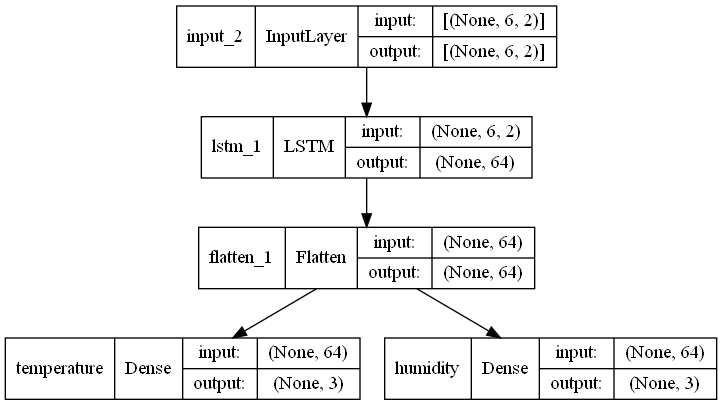

In [23]:
from keras.models import Model

output_steps=3
input_steps=6

# lstm=tf.keras.Sequential([
#     layers.LSTM(64),
#     layers.Flatten(),
#     layers.Dense(units=2)
# ])


input_stuff=keras.Input(shape=(input_steps,2))
x=layers.LSTM(64)(input_stuff)
x=layers.Flatten()(x)
temperature=layers.Dense(units=output_steps,name='temperature')(x)# we give temperature labels to this part 
humidity=layers.Dense(units=output_steps,name='humidity')(x)#we give humidity labels to this part

# loss=tf.losses.MeanSquaredError()

optimizer=tf.optimizers.Adam()


lstm = Model(inputs=input_stuff,outputs=[temperature, humidity])

lstm.summary()

tf.keras.utils.plot_model(lstm,show_shapes=True)


In [24]:
# Specify the optimizer, and compile the model with loss functions for both outputs
lstm.compile(optimizer=optimizer,
              loss={'temperature': 'mse', 'humidity': 'mse'},
 metrics={'temperature':tf.keras.metrics.MeanAbsoluteError(),
          'humidity':tf.keras.metrics.MeanAbsoluteError()})

In [26]:
x_train,y_train=window_gen(train_data,input_steps,output_steps,False)

# x_mean_lstm,y_mean_lstm,x_std_lstm,y_std_lstm=mean_std(x_train,y_train)

# x_train_norm,y_train_norm=normalization(x_train,y_train,x_mean_lstm,y_mean_lstm,x_std_lstm,y_std_lstm)

y_temperature=y_train[:,:,0]
y_humidity=y_train[:,:,1]
lstm.fit(x_train,[y_temperature,y_humidity],batch_size=32,epochs=10) 

Epoch 1/10
9200/9200 [==============================] - 23s 3ms/step - loss: 10.8675 - temperature_loss: 3.1273 - humidity_loss: 7.7403 - temperature_mean_absolute_error: 0.8477 - humidity_mean_absolute_error: 1.6343
Epoch 2/10
9200/9200 [==============================] - 23s 2ms/step - loss: 3.9398 - temperature_loss: 0.2271 - humidity_loss: 3.7127 - temperature_mean_absolute_error: 0.3300 - humidity_mean_absolute_error: 1.2002
Epoch 3/10
9200/9200 [==============================] - 22s 2ms/step - loss: 3.8214 - temperature_loss: 0.2007 - humidity_loss: 3.6206 - temperature_mean_absolute_error: 0.3055 - humidity_mean_absolute_error: 1.1794
Epoch 4/10
9200/9200 [==============================] - 23s 3ms/step - loss: 3.7546 - temperature_loss: 0.1852 - humidity_loss: 3.5694 - temperature_mean_absolute_error: 0.2902 - humidity_mean_absolute_error: 1.1674
Epoch 5/10
9200/9200 [==============================] - 23s 3ms/step - loss: 3.7077 - temperature_loss: 0.1776 - humidity_loss: 3.5301 

In [27]:
yhat = lstm.predict(x_train, verbose=2)
print(yhat)

9200/9200 - 9s - 9s/epoch - 967us/step
[array([[-7.7390575, -7.671955 , -7.6511   ],
       [-7.1539745, -7.03901  , -6.97838  ],
       [-7.55019  , -7.4653854, -7.4331408],
       ...,
       [14.873356 , 14.871209 , 14.934268 ],
       [15.071829 , 15.077382 , 15.146464 ],
       [14.455219 , 14.420535 , 14.448773 ]], dtype=float32), array([[94.07855 , 94.009766, 93.785675],
       [94.48122 , 94.3002  , 93.987366],
       [94.515045, 94.411804, 94.12756 ],
       ...,
       [95.33278 , 95.25475 , 95.1232  ],
       [94.83707 , 94.71042 , 94.56146 ],
       [95.47112 , 95.50137 , 95.44098 ]], dtype=float32)]


<b>Run the below cells for validation and testing for the output steps of 3<b>

In [28]:
output_steps=3
input_steps=6

x_val3,y_val3=window_gen(val_data,input_steps,output_steps,False)
x_test3,y_test3=window_gen(test_data,input_steps,output_steps,False)


# x_val_norm3,y_val_norm3=normalization(x_val3,y_val3,x_mean_lstm,y_mean_lstm,x_std_lstm,y_std_lstm)
# x_test_norm3,y_test_norm3=normalization(x_test3,y_test3,x_mean_lstm,y_mean_lstm,x_std_lstm,y_std_lstm)

In [22]:
x_test_norm3

array([[[-0.7288558 ,  0.6096731 ],
        [-0.7288704 ,  0.6036326 ],
        [-0.7346641 ,  0.61571175],
        [-0.73698777,  0.6096706 ],
        [-0.7439333 ,  0.597591  ],
        [-0.74972355,  0.6096703 ]],

       [[-0.7288558 ,  0.60363334],
        [-0.73464817,  0.61571205],
        [-0.7369752 ,  0.609672  ],
        [-0.7439212 ,  0.59759116],
        [-0.74971116,  0.6096704 ],
        [-0.7543459 ,  0.6217497 ]],

       [[-0.73463356,  0.61571276],
        [-0.7369593 ,  0.6096723 ],
        [-0.7439085 ,  0.5975926 ],
        [-0.74969906,  0.6096706 ],
        [-0.7543335 ,  0.6217498 ],
        [-0.7601238 ,  0.62778986]],

       ...,

       [[-1.3863603 , -0.21778044],
        [-1.4245131 , -0.27213913],
        [-1.5239136 , -0.07886552],
        [-1.566686  ,  0.3258003 ],
        [-1.5251008 ,  0.16272546],
        [-1.4869827 , -0.20570192]],

       [[-1.4244932 , -0.2721388 ],
        [-1.5238905 , -0.07886556],
        [-1.5666693 ,  0.32580152],
       

In [21]:
x_test3

array([[[ 2.8 , 86.  ],
        [ 2.8 , 85.9 ],
        [ 2.75, 86.1 ],
        [ 2.73, 86.  ],
        [ 2.67, 85.8 ],
        [ 2.62, 86.  ]],

       [[ 2.8 , 85.9 ],
        [ 2.75, 86.1 ],
        [ 2.73, 86.  ],
        [ 2.67, 85.8 ],
        [ 2.62, 86.  ],
        [ 2.58, 86.2 ]],

       [[ 2.75, 86.1 ],
        [ 2.73, 86.  ],
        [ 2.67, 85.8 ],
        [ 2.62, 86.  ],
        [ 2.58, 86.2 ],
        [ 2.53, 86.3 ]],

       ...,

       [[-2.89, 72.3 ],
        [-3.22, 71.4 ],
        [-4.08, 74.6 ],
        [-4.45, 81.3 ],
        [-4.09, 78.6 ],
        [-3.76, 72.5 ]],

       [[-3.22, 71.4 ],
        [-4.08, 74.6 ],
        [-4.45, 81.3 ],
        [-4.09, 78.6 ],
        [-3.76, 72.5 ],
        [-3.93, 72.6 ]],

       [[-4.08, 74.6 ],
        [-4.45, 81.3 ],
        [-4.09, 78.6 ],
        [-3.76, 72.5 ],
        [-3.93, 72.6 ],
        [-4.05, 73.1 ]]], dtype=float32)

In [30]:
y_val_predict_lstm3=lstm.predict(x_val3,verbose=2)

2629/2629 - 3s - 3s/epoch - 974us/step


In [31]:
y_val_predict_lstm3

[array([[13.752139 , 13.770103 , 13.8444395],
        [13.607848 , 13.621939 , 13.693038 ],
        [13.590975 , 13.61456  , 13.694638 ],
        ...,
        [ 2.727688 ,  2.7330096,  2.7721615],
        [ 2.847884 ,  2.8563426,  2.8986578],
        [ 2.851495 ,  2.8579857,  2.8980556]], dtype=float32),
 array([[97.68934 , 97.59302 , 97.43286 ],
        [98.121185, 98.04272 , 97.88782 ],
        [98.113235, 97.99097 , 97.80299 ],
        ...,
        [89.857666, 89.76277 , 89.66376 ],
        [89.54118 , 89.4272  , 89.31853 ],
        [88.98436 , 88.86072 , 88.74704 ]], dtype=float32)]

In [32]:
y_test_predict_lstm3=lstm.predict(x_test3,verbose=2)

1314/1314 - 1s - 1s/epoch - 1ms/step


In [34]:
y_val_temperature_lstm3=y_val3[:, 0::2]
y_val_humidity_lstm3=y_val3[:, 1::2]
y_val_temperature_predict_lstm3=y_val_predict_lstm3[:, 0::2]
y_val_humidity_predict_lstm3=y_val_predict_lstm3[:, 1::2]


y_test_temperature_lstm3=y_test3[:, 0::2]
y_test_humidity_lstm3=y_test3[:, 1::2]
y_test_temperature_predict_lstm3=y_test_predict_lstm3[:, 0::2]
y_test_humidity_predict_lstm3=y_test_predict_lstm3[:, 1::2]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
val_temperature_mae_lstm3=tf.keras.metrics.mean_absolute_error(y_val_temperature_lstm3,y_val_temperature_predict_lstm3)
print(np.mean(val_temperature_mae_lstm3))

In [ ]:
val_humidity_mae3=tf.keras.metrics.mean_absolute_error(y_val_humidity_lstm3,y_val_humidity_predict_lstm3)
print(np.mean(val_humidity_mae3))

In [ ]:
test_temperature_mae_lstm3=tf.keras.metrics.mean_absolute_error(y_test_temperature_lstm3,y_test_temperature_predict_lstm3)
print(np.mean(test_temperature_mae_lstm3))

In [ ]:
test_humidity_mae3=tf.keras.metrics.mean_absolute_error(y_test_humidity_lstm3,y_test_humidity_predict_lstm3)
print(np.mean(test_humidity_lstm3))

<b>Run the below cells for validation and testing for output steps of 9<b>

In [ ]:
#creating the val and test dataset and normalization

output_steps=9
input_steps=6

x_val9,y_val9=window_gen(val_data,input_steps,output_steps,True)
x_test9,y_test9=window_gen(test_data,input_steps,output_steps,True)


x_val_norm9,y_val_norm9=normalization(x_val9,y_val9,x_mean_lstm,y_mean_lstm,x_std_lstm,y_std_lstm)
x_test_norm9,y_test_norm9=normalization(x_test9,y_test9,x_mean_lstm,y_mean_lstm,x_std_lstm,y_std_lstm)

In [ ]:
y_val_predict_lstm9=lstm.predict(x_val_norm9,verbose=2)

In [ ]:
y_test_predict_lstm9=lstm.predict(x_test_norm9,verbose=2)

In [ ]:
y_val_predict_lstm9=lstm.predict(x_val_norm9,verbose=2)
val_mae_lstm9=tf.keras.metrics.mean_absolute_error(y_val_norm9,y_val_predict_lstm9)
print(np.mean(val_mae_lstm9))

In [ ]:
y_val_temperature_lstm9=y_val_norm9[:, 0::2]
y_val_humidity_lstm9=y_val_norm9[:, 1::2]
y_val_temperature_predict_lstm9=y_val_predict_lstm9[:, 0::2]
y_val_humidity_predict_lstm9=y_val_predict_lstm9[:, 1::2]


y_test_temperature_lstm9=y_test_norm9[:, 0::2]
y_test_humidity_lstm9=y_test_norm9[:, 1::2]
y_test_temperature_predict_lstm9=y_test_predict_lstm9[:, 0::2]
y_test_humidity_predict_lstm9=y_test_predict_lstm9[:, 1::2]

In [ ]:
val_temperature_mae_lstm9=tf.keras.metrics.mean_absolute_error(y_val_temperature_lstm9,y_val_temperature_predict_lstm9)
print(np.mean(val_temperature_mae_lstm9))


In [ ]:
val_humidity_mae9=tf.keras.metrics.mean_absolute_error(y_val_humidity_lstm9,y_val_humidity_predict_lstm9)
print(np.mean(val_humidity_mae9))

In [ ]:
test_temperature_mae_lstm9=tf.keras.metrics.mean_absolute_error(y_test_temperature_lstm9,y_test_temperature_predict_lstm9)
print(np.mean(test_temperature_mae_lstm9))

In [ ]:
test_humidity_mae9=tf.keras.metrics.mean_absolute_error(y_test_humidity_lstm9,y_test_humidity_predict_lstm9)
print(np.mean(test_humidity_mae9))

<b>Run the below cells for the pruning procedure</b></br>
<b>We have to use the normalized train and test data <br>
We have to consider the number of outputs in order to use the right test data (3 or 9) </b> <br>
 x_test_norm3, y_test_norm3<br>
<b>OR</b> <br>
 x_test_norm9, y_test_norm9 <br>

In [ ]:
import tensorflow_model_optimization as tfmot
import tempfile
# prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
# model_for_pruning = prune_low_magnitude(cnn)

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 20 #best values are either 9 or 10
validation_split = 0.2  # 10% of training set will be used for validation set.

num_images = 294370 * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                             final_sparsity=0.9,
                                                             begin_step=0,
                                                             end_step=end_step)
}

model_for_pruning = prune_low_magnitude(lstm, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.MeanAbsoluteError(),
                          metrics=['mae'])

model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train_norm, y_train_norm,
                      batch_size=batch_size, epochs=epochs, callbacks=callbacks)
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
    x_test_norm3, y_test_norm3, verbose=0)

print('Pruned test accuracy:', model_for_pruning_accuracy)
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

In [ ]:
import zlib, sys

filename_in = "C:/Users/aligh/AppData/Local/Temp/tmpuq0ot4o4.tflite"
filename_out = "./compressed_cnn9.tflite.zlib"

with open(filename_in, mode="rb") as fin, open(filename_out, mode="wb") as fout:
    data = fin.read()
    compressed_data = zlib.compress(data, 9)
    print(f"Original size: {sys.getsizeof(data)}")
    # Original size: 1000033
    print(f"Compressed size: {sys.getsizeof(compressed_data)}")
    # Compressed size: 1024

    fout.write(compressed_data)

<b>MAE for the pruned model  <br>
(The MAE of the models after the pruning)</b> <br>

 <b>output=9

In [ ]:
y_test_predict_lstm9_prune=model_for_pruning.predict(x_test_norm9,verbose=2)

In [ ]:
y_test_temperature_lstm9=y_test_norm9[:, 0::2]
y_test_humidity_lstm9=y_test_norm9[:, 1::2]
y_test_temperature_predict_lstm9_prune=y_test_predict_lstm9_prune[:, 0::2]
y_test_humidity_predict_lstm9_prune=y_test_predict_lstm9_prune[:, 1::2]


In [ ]:
test_temperature_mae_lstm9_prune=tf.keras.metrics.mean_absolute_error(y_test_temperature_lstm9,y_test_temperature_predict_lstm9_prune)
print(np.mean(test_temperature_mae_lstm9_prune))

In [ ]:
test_humidity_mae_lstm9_prune=tf.keras.metrics.mean_absolute_error(y_test_humidity_lstm9,y_test_humidity_predict_lstm9_prune)
print(np.mean(test_humidity_mae_lstm9_prune))

<b>output=3

In [ ]:
y_test_predict_lstm3_prune=model_for_pruning.predict(x_test_norm3,verbose=2)

In [ ]:
y_test_temperature_lstm3=y_test_norm3[:, 0::2]
y_test_humidity_lstm3=y_test_norm3[:, 1::2]
y_test_temperature_predict_lstm3_prune=y_test_predict_lstm3_prune[:, 0::2]
y_test_humidity_predict_lstm3_prune=y_test_predict_lstm3_prune[:, 1::2]


In [ ]:
test_temperature_mae_lstm3_prune=tf.keras.metrics.mean_absolute_error(y_test_temperature_lstm3,y_test_temperature_predict_lstm3_prune)
print(np.mean(test_temperature_mae_lstm3_prune))

In [ ]:
test_humidity_mae_lstm3_prune=tf.keras.metrics.mean_absolute_error(y_test_humidity_lstm3,y_test_humidity_predict_lstm3_prune)
print(np.mean(test_humidity_mae_lstm3_prune))

<b> Best options:</b> <br>

<b>Values for output=3  : <br>
Model= CNN<br>
alpha= 0.25<br>
mae (temperature)(before pruning): 0.06391374<br>
mae (humidity)(before pruning): 0.069080375<br>
mae (temperature)(after pruning): 0.029551366<br>
mae (humidity)(after pruning):0.07264139<br>
size:1.6 kb<br> </b>
==================================================================== <br>
<b>Values for output=9  : <br>
Model= CNN<br>
alpha= 0.25<br>
mae (temperature)(before pruning): 0.055685066<br>
mae (humidity)(before pruning):0.13104069<br>
mae (temperature)(after pruning):0.07200625 <br> 
mae (humidity)(after pruning): 0.14742073<br>
size:1.81 kb<br>
</b>